vector weights.
categorical distribution.
softmax probabilities.

Gumbel rv sampling
proof or ref.

empirically show probabilites

softmax relaxation of argmax
temperature for relaxation
effect of changing temperature.

binary

VAE
relaxed v. discrete difference

KL divergence

# Sampling Discrete Structures

In these tutorials we discuss methods for sampling discrete variables from unstructured vectors to more structured objects such as subsets, permutations and graphs which can be incorporated in differentiable models.

At the foundation of these methods are continuous relaxations for discrete (binary or categorical) random variables. 
So the first part of the tutorial gives an introduction to sampling form discrete distributions with the Gumbel-Softmax trick.
We use the method to train a variational autoencoder with categorical latent variables.

## Categorical Sampling with Gumbel-Argmax

Suppose we are given a categorical distribution with $C$ values as weights $w_i \in (0,\infty)$. 
We would like to obtain a sample from this distribution.
The probablity of each category $c_i$ is given by the following softmax distribution
$$p_i = \frac{\exp(\log(w_i))}{\sum_j \exp(\log(w_j))}$$

The Gumbel-Argmax method for sampling this distribution is the following:
Sample $U_k \sim Uniform(0,1)$ iid and compute $r_k = \log\alpha_k -log(-\log U_k)$. Then choose the index $i$ of the maximum $r_k$ (ie take the argmax) and return the 1-hot vector with the $i$th index set to 1 and the rest to 0.
The form of noise $-log(-\log U_k)$ added to form $r_k$ has a Gumbel distribution whence the method gets its name. The cumulative distribution function of the Gumbel distribution (with location 0 and scale 1) is given as
$$F(z) = \exp(\exp(-z))$$

You can take a look at a proof that this indeed samples from the softmax distribution [here](https://lips.cs.princeton.edu/the-gumbel-max-trick-for-discrete-distributions/).

In short sampling a categorical variable with the Gumbel reparameterization proceeds as follows.
1. Given weights $w_i$ compute $r_i = w_i+g_i$ where $g_i$ are iid Gumbel samples
2. Argmax: Return index of largest $r_i$ as a 1-hot vector

## Softmax Relaxation

The above procedure still cannot be used in a differentiable model since the argmax operation has zero gradient except at points of discontinuity. 
So instead we use the `softmax` as a differentiable approximation to the argmax.
In order to control the approximation we introduce a tunable temperature hyperparameter $\tau$ which controls how far the softmax outputs are from being 1-hot. 

$$p_i = \frac{\exp(r_i/\tau)}{\sum_j \exp(r_j/\tau)}$$

The following figure ([Paper Link](https://arxiv.org/abs/1611.01144)) shows the effect of temperature on the distribution and samples.


![Image](img/temp.png)


A smaller temperature indicates a tigther approximation and the larger the temperature the looser the approximation.
Of course, if the temperature is too small we wouldn't be able to train the model since the gradients would be very small.
On the other hand, a large temperature would make the categorical outputs very far from being discrete, so it is important to choose an appropriate temperature for the problem at hand.
One possiblity is to slowly anneal the temperature from large to small so that close to the end of training the relaxed categorical outputs are closed to discrete.
In practice, however, the temperature is often kept fixed during each training trial and tuned with cross-validation.

With the softmax relaxation the sampling then proceeds as follows

1. Given weights $w_i$ compute $r_i = w_i+g_i$ where $g_i$ are iid Gumbel samples
2. Apply softmax with temperature to obtain a relaxed categorical sample

## Categorical VAE

As an example of the Gumbel Softmax relaxation we show a VAE with a categorical variable latent space for MNIST. The latent space has the structure of a vector of categorical variables each with the same fixed number of categories. 
In the following example the latent space has 30 categorical variables each of dimension 10.
Since this is a VAE we also need to define a prior on the latent space which we define to be the uniform categorical distribution.

The following implementation uses code from [here](https://github.com/YongfeiYan/Gumbel_Softmax_VAE) with minor modification.

We being with the required imports and hyperparameter definitions.

In [1]:
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.distributions.one_hot_categorical import OneHotCategorical
%matplotlib inline

cuda=True

In [2]:
batch_size = 100
epochs = 10
latent_dim = 30
categorical_dim = 10 
temp = 1.0

### Gumbel Sampling

We now define the Gumbel-Softmax sampling routines. The `sample_gumbel` function samples scale 0 location 1 Gumbel variables by sampling uniform random variables in $U(0,1)$ and computing $-\log(-\log(U(0,1))$.
The categorical parameters are input as unnormalized log probabilities.
The `gumbel_softmax_sample` function adds the Gumbel noise to the logits, applies the temperature and the softmax function.
In the `gumbel_softmax` function we also add evaluation code which simply returns a sample (unrelaxed) from the categorical distribution parameterized by `logits`.

In [3]:
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    if cuda:
        U = U.cuda()
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature, evaluate=False):
    if evaluate:
        d =  OneHotCategorical(logits=logits.view(-1, latent_dim, categorical_dim))
        return d.sample().view(-1, latent_dim * categorical_dim)
    
    y = gumbel_softmax_sample(logits, temperature)
    return y.view(-1, latent_dim * categorical_dim)

### VAE model
Now we define the VAE model.
The encoder computes the categorical probability parameters from which relaxed categorical variables can be sampled and passed into the decoder.

In [4]:
class VAE_gumbel(nn.Module):
    def __init__(self, temp):
        super(VAE_gumbel, self).__init__()

        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, latent_dim * categorical_dim)

        self.fc4 = nn.Linear(latent_dim * categorical_dim, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, 784)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return self.relu(self.fc3(h2))

    def decode(self, z):
        h4 = self.relu(self.fc4(z))
        h5 = self.relu(self.fc5(h4))
        return self.sigmoid(self.fc6(h5))

    def forward(self, x, temp, evaluate=False):
        q = self.encode(x.view(-1, 784))
        q_y = q.view(q.size(0), latent_dim, categorical_dim)
        z = gumbel_softmax(q_y, temp, evaluate)
        return self.decode(z), F.softmax(q_y, dim=-1).reshape(*q.size())

### KL Divergence
Since this is a VAE we also need to compute a KL divergence of the latent probability distribution with the uniform prior $p(x) = 1/C$ for all $x$ where $C$ is the total number of categories.

\begin{align}
KLD(q||p) &= E_q\left[\log\frac{q(x)}{p(x)}\right]\\
        &= \sum_{i=1}^{C} q(x_i) \log (C \cdot q(x_i))
\end{align}

Here $q(x)$ is the latent probability distribution

Finally we compute the reconstruction loss of the input as the binary cross entropy between the reconstruction parameters and the input image and add that to the KL divergence to get the VAE loss.

In [5]:
def loss_function(recon_x, x, qy):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), size_average=False) / x.shape[0]

    log_ratio = torch.log(qy * categorical_dim + 1e-20)
    KLD = torch.sum(qy * log_ratio, dim=-1).mean()

    return BCE + KLD

Next we build the model and train

In [6]:
model = VAE_gumbel(temp)
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [7]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

/home/apervez/anaconda3/envs/pytorch1.9_2/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


For training we compute both the relaxed and the unrelaxed objective.
The unrelaxed objective is not itself used for training. 
However, since that's the objective we want to improve, it's a good idea to also evaluate it so that we can observe how far the relaxed objective is from the actual objective.
This also allows us to get an idea of how low or high to set the temperature so that the relaxed objective is not too far from the true objective while achieving reasonable training performance.

In [8]:
def train(epoch):
    model.train()
    train_loss = 0
    train_loss_unrelaxed = 0
    #temp = args.temp
    for batch_idx, (data, _) in enumerate(train_loader):
        if cuda:
            data = data.cuda()
        optimizer.zero_grad()
        recon_batch, qy = model(data, temp)
        loss = loss_function(recon_batch, data, qy)
        loss.backward()
        train_loss += loss.item() * len(data)
        optimizer.step()
        
        #Unrelaxed training objective for comparison
        recon_batch_eval, qy_eval = model(data, temp, evaluate=True)
        loss_eval = loss_function(recon_batch_eval, data, qy_eval)
        train_loss_unrelaxed += loss_eval.item() * len(data)
        
    print('====> Epoch: {} Average loss relaxed: {:.4f} Unrelaxed: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset) , train_loss_unrelaxed / len(train_loader.dataset)))


In [9]:
def test(epoch):
    model.eval()
    test_loss = 0
    for i, (data, _) in enumerate(test_loader):
        if cuda:
            data = data.cuda()
        recon_batch, qy = model(data, temp, evaluate=True)
        test_loss += loss_function(recon_batch, data, qy).item() * len(data)
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


Finally we can run the training. 
You can try training with different values of the temperature to see how that affects the relaxed objective relative to the true one.

In [10]:
def run():
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
run()

/home/apervez/anaconda3/envs/pytorch1.9_2/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


====> Epoch: 1 Average loss relaxed: 196.7733 Unrelaxed: 199.3215
====> Test set loss: 177.6476
====> Epoch: 2 Average loss relaxed: 153.2156 Unrelaxed: 161.5222
====> Test set loss: 151.0515
====> Epoch: 3 Average loss relaxed: 136.7048 Unrelaxed: 147.1678
====> Test set loss: 144.1774
====> Epoch: 4 Average loss relaxed: 128.7209 Unrelaxed: 141.0000
====> Test set loss: 138.0207
====> Epoch: 5 Average loss relaxed: 123.8051 Unrelaxed: 137.0583
====> Test set loss: 135.2185
====> Epoch: 6 Average loss relaxed: 120.1667 Unrelaxed: 134.3406
====> Test set loss: 132.9374
====> Epoch: 7 Average loss relaxed: 117.7523 Unrelaxed: 132.6021
====> Test set loss: 131.5883
====> Epoch: 8 Average loss relaxed: 115.7770 Unrelaxed: 131.1220
====> Test set loss: 129.9874
====> Epoch: 9 Average loss relaxed: 114.4366 Unrelaxed: 130.0187
====> Test set loss: 129.7259
====> Epoch: 10 Average loss relaxed: 113.2691 Unrelaxed: 129.0841
====> Test set loss: 128.8101


### Generating Samples
We can now generate some samples from the trained decoder.
For this we sample some uniform categorical variables from the prior and pass them into the decoder.

In [11]:
def generate_samples():
    #generate uniform probability vector
    model.eval()
    probs = torch.ones([64, latent_dim, categorical_dim])*(1/categorical_dim)
    cat_samples = OneHotCategorical(probs=probs.cuda()).sample().view(-1, latent_dim*categorical_dim)
    output = model.decode(cat_samples)
    return output.view(-1,28,28).detach().cpu().numpy()


In [12]:
samples = generate_samples()

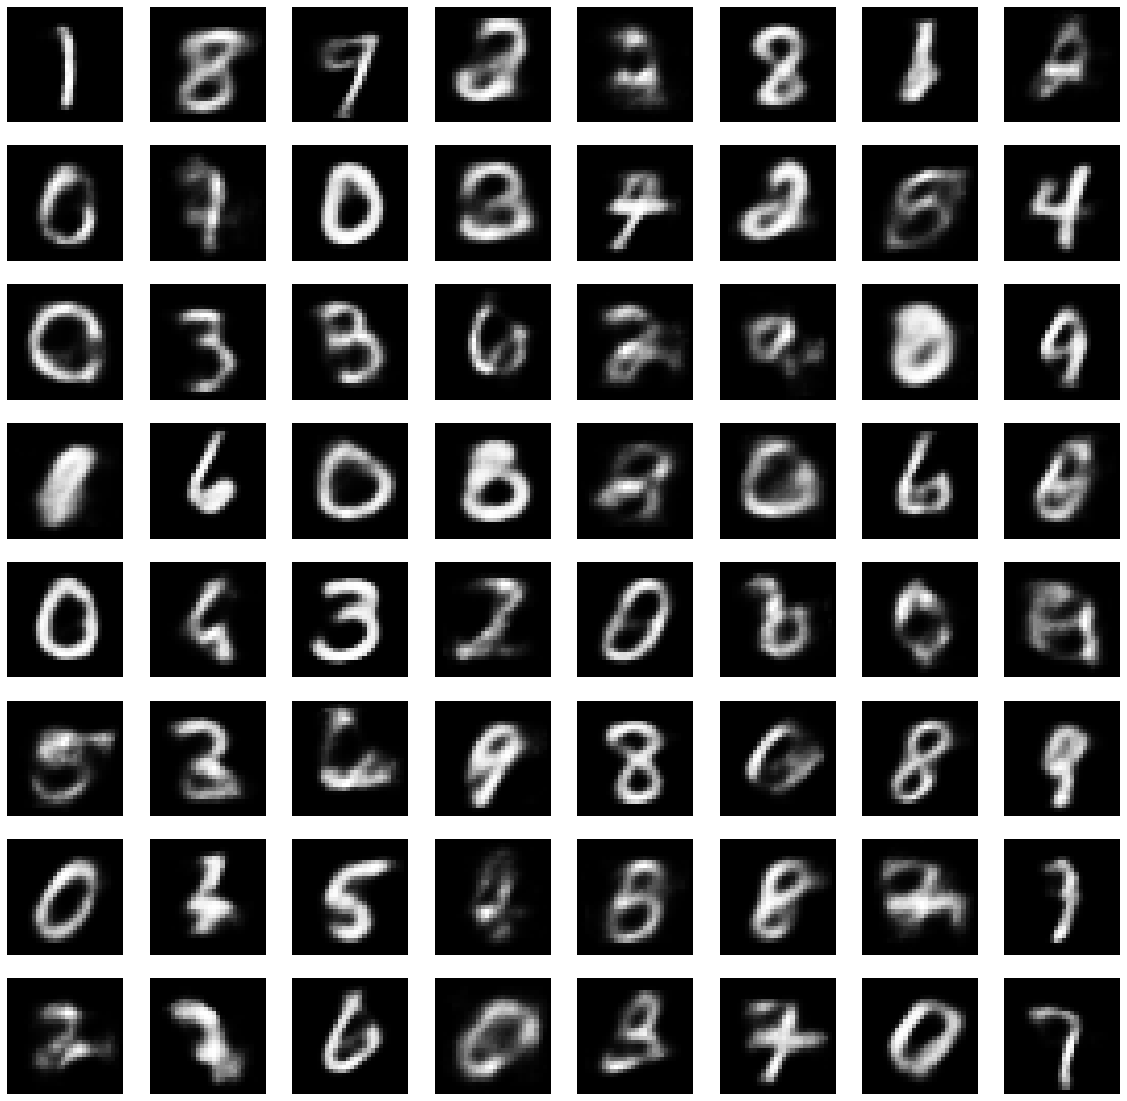

In [13]:
from utils import show_gray_image_grid
%matplotlib inline
show_gray_image_grid(samples, 8,8)

## References

[Categorical Reparameterization with Gumbel-Softmax](https://arxiv.org/abs/1611.01144)

[The Concrete Distribution: A Continuous Relaxation of Discrete Random Variables](https://arxiv.org/abs/1611.00712)